## Agents



Agents can handle sophisticated tasks, but their implementation is often straightforward. They are typically just LLMs using tools based on environmental feedback in a loop. It is therefore crucial to design toolsets and their documentation clearly and thoughtfully.

When to use agents: Agents can be used for open-ended problems where it’s difficult or impossible to predict the required number of steps, and where you can’t hardcode a fixed path. The LLM will potentially operate for many turns, and you must have some level of trust in its decision-making. Agents' autonomy makes them ideal for scaling tasks in trusted environments.

Resource: [Building Effective Agents](https://www.anthropic.com/engineering/building-effective-agents)


![](58d9f10c985c4eb5d53798dea315f7bb5ab6249e-2401x1000.webp)

![](4b9a1f4eb63d5962a6e1746ac26bbc857cf3474f-2400x1666.webp)

### Why LangGraph?

#### Core Problems LangGraph Solves

- **Cycles & Loops**: Traditional chains are linear; agents need to iterate, retry, and loop back
- **State Management**: Agents need memory to track progress across complex workflows
- **Multi-Agent Coordination**: Complex tasks require multiple agents working together
- **Production Reliability**: Need persistence, error recovery, and human oversight

#### Key Benefits

**Control & Flexibility**
- Low-level orchestration without abstraction
- Full control over prompts, architecture, and decision flow
- Support for both workflows (predictable) and agents (autonomous)

**Production Features**
- **Durable Execution**: Agents persist through failures and resume automatically
- **Human-in-the-Loop**: Add oversight and approval steps anywhere
- **Comprehensive Memory**: Short-term and long-term state management
- **Debugging**: Visual tools for tracing execution and state transitions

**Advanced Workflows**
- **Cyclical Processes**: Agents can loop, reflect, and iterate
- **Multi-Agent**: Multiple specialized agents collaborate on complex tasks
- **Conditional Logic**: Dynamic routing based on agent decisions
- **Graph Structure**: Nodes (agents/functions) connected by edges (data flow)

#### **When to Use LangGraph**

**Use LangGraph for:**
- Complex, multi-step workflows
- Agents that need to iterate/retry
- Long-running processes
- Multi-agent systems
- Production deployments requiring reliability

**Use Simple LangChain for:**
- Linear question-answering
- Basic tool calling
- Quick prototypes
- Predictable workflows

More on LangGraph: https://academy.langchain.com/courses/intro-to-langgraph

In [ ]:
!pip install langgraph

In [1]:
from langchain_openai import ChatOpenAI

llm_model="gpt-4o-mini"
llm = ChatOpenAI(temperature=0.0, model=llm_model)

In [2]:
from langchain_core.tools import tool


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [4]:
from langgraph.graph import add_messages
from langgraph.func import entrypoint, task

from langchain_core.messages import (
    SystemMessage,
    HumanMessage,
    BaseMessage,
    ToolCall,
)

# nodes defined
# decision node, LLM decides whether to call a tool or not

@task
def call_llm(messages: list[BaseMessage]):
    """LLM decides whether to call a tool or not"""
    return llm_with_tools.invoke( 
        [
            SystemMessage(
                content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
            )
        ]
        + messages # output saved to messages, this messages get accumulated as the llm calls different tools and gets the response
    )


@task # tool node, look at the last message and if that's a tool, then calls the tool
def call_tool(tool_call: ToolCall):
    """Performs the tool call"""
    tool = tools_by_name[tool_call["name"]]
    return tool.invoke(tool_call)


@entrypoint() # start the agent - agent control flow
def agent(messages: list[BaseMessage]):
    llm_response = call_llm(messages).result()

    while True:
        if not llm_response.tool_calls: # Continues until tool call is not needed
            break

        # Execute tools
        tool_result_futures = [
            call_tool(tool_call) for tool_call in llm_response.tool_calls
        ]
        tool_results = [fut.result() for fut in tool_result_futures]
        messages = add_messages(messages, [llm_response, *tool_results])
        llm_response = call_llm(messages).result()

    messages = add_messages(messages, llm_response)
    return messages

# Invoke
messages = [HumanMessage(content="Add 3 and 4")]
for chunk in agent.stream(messages, stream_mode="updates"): # stream real-time updates as agent works
    print(chunk)
    print("\n")

{'call_llm': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tOptO2FC2ykwp0jLMenIiQC8', 'function': {'arguments': '{"a":3,"b":4}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 149, 'total_tokens': 166, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_62a23a81ef', 'id': 'chatcmpl-BdX6ely6SpD3ZAMiIH7uIeKLwaCdS', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--37f7ec5c-32d1-426b-8fb3-9a9024dbebd4-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 4}, 'id': 'call_tOptO2FC2ykwp0jLMenIiQC8', 'type': 'tool_call'}], usage_metadata={'input_tokens': 149, 'output_tokens': 17, 'total_tokens': 166, 'input_token_details': {'audio': 0

Langsmith trace: https://smith.langchain.com/public/42ae8bf9-3935-4504-a081-8ddbcbfc8b2e/r

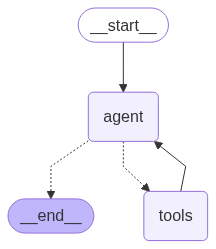

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_zaQVBUPKQQHTd92MuSpjSrpT)
 Call ID: call_zaQVBUPKQQHTd92MuSpjSrpT
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [24]:
from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display

# Pass in:
# (1) the augmented LLM with tools
# (2) the tools list (which is used to create the tool node)
pre_built_agent = create_react_agent(llm, tools=tools)

# Show the agent
display(Image(pre_built_agent.get_graph().draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
messages = pre_built_agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

In [5]:
messages = [HumanMessage(content="Add 3 and 4, then multiply by 2")]
for chunk in agent.stream(messages, stream_mode="updates"):
    print(chunk)
    print("\n")

{'call_llm': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_p1qhrhNxLU90rk5z9XwEEfz8', 'function': {'arguments': '{"a":3,"b":4}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 155, 'total_tokens': 172, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_62a23a81ef', 'id': 'chatcmpl-BdXCIaooFrvXqWlCuWDM2Ch073Q4W', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--76101f48-6344-4893-a079-fbef5858a656-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 4}, 'id': 'call_p1qhrhNxLU90rk5z9XwEEfz8', 'type': 'tool_call'}], usage_metadata={'input_tokens': 155, 'output_tokens': 17, 'total_tokens': 172, 'input_token_details': {'audio': 0

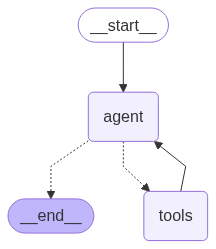

================================ Human Message =================================

Add 3 and 4, then multiply by 2
================================== Ai Message ==================================
Tool Calls:
  add (call_NlIqa1kn6RquUSJFTeRZhC1S)
 Call ID: call_NlIqa1kn6RquUSJFTeRZhC1S
  Args:
    a: 3
    b: 4
  multiply (call_lUEHt2uKE4c4TtJsIS80WMdM)
 Call ID: call_lUEHt2uKE4c4TtJsIS80WMdM
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: add

7
================================= Tool Message =================================
Name: multiply

4
================================== Ai Message ==================================
Tool Calls:
  multiply (call_11S9wk717vUU4zXZxIId4qRs)
 Call ID: call_11S9wk717vUU4zXZxIId4qRs
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

Fir

In [6]:
from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display

# Pass in:
# (1) the augmented LLM with tools
# (2) the tools list (which is used to create the tool node)
pre_built_agent = create_react_agent(llm, tools=tools)

# Show the agent
display(Image(pre_built_agent.get_graph().draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Add 3 and 4, then multiply by 2")]
messages = pre_built_agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

In [7]:
messages = [HumanMessage(content="Add 3 and 4, then multiply by 5, then divide it by 7")]
messages = pre_built_agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4, then multiply by 5, then divide it by 7
================================== Ai Message ==================================
Tool Calls:
  add (call_BB5Rs4sgiao028Qz6krrVuBj)
 Call ID: call_BB5Rs4sgiao028Qz6krrVuBj
  Args:
    a: 3
    b: 4
  multiply (call_GQlSH9C7CJZAm5TQnsdwElVa)
 Call ID: call_GQlSH9C7CJZAm5TQnsdwElVa
  Args:
    a: 7
    b: 5
================================= Tool Message =================================
Name: add

7
================================= Tool Message =================================
Name: multiply

35
================================== Ai Message ==================================
Tool Calls:
  divide (call_egdf10bH4rEQgPqoxRM0puEs)
 Call ID: call_egdf10bH4rEQgPqoxRM0puEs
  Args:
    a: 35
    b: 7
================================= Tool Message =================================
Name: divide

5.0
================================== Ai Message ===================